In [31]:
%matplotlib inline
import pandas as pd
import numpy as np
#import geopandas as gpd
import pylab as plt
#import geopandas as gpd
import matplotlib.colors as colors

In [32]:
# input data files
input_data = []
idx_start = 0
for y in range(2013,2019):
    df = pd.read_excel("kwb-%s.xlsx"%y, sheet_name="_KWB%s"%y)
    df.loc[:,'year'] = y
    df.index += idx_start
    idx_start += len(df)
    input_data.append(df)
input_data[0].head()

,gwb_code_10,gwb_code_8,regio,gm_naam,recs,gwb_code,a_inw,a_man,a_vrouw,p_00_14,...,a_ha_bnt,p_pc_nst,p_pc_at,p_pc_bnt,pst_mvp,pst_dekp,ste_mvs,ste_oad,ind_wbi,year
0,NL00,0,Nederland,Nederland,Land,NL00,16779575,8307340,8472235,17,...,.,.,.,.,.,.,2,1923,.,2013
1,GM0003,3,Appingedam,Appingedam,Gemeente,GM0003,12050,5835,6215,15,...,.,.,.,.,.,.,3,1016,.,2013
2,WK000300,300,Wijk 00,Appingedam,Wijk,WK000300,12050,5835,6215,15,...,.,.,.,.,.,.,3,1016,1,2013
3,BU00030000,30000,Appingedam-Centrum,Appingedam,Buurt,BU00030000,2305,1075,1230,10,...,.,.,.,.,9901,1,3,1139,1,2013
4,BU00030001,30001,Appingedam-West,Appingedam,Buurt,BU00030001,3165,1575,1595,18,...,.,.,.,.,9903,5,4,854,1,2013


In [33]:
for d in input_data:
    print(d.index)

RangeIndex(start=0, stop=15057, step=1)
RangeIndex(start=15057, stop=30212, step=1)
RangeIndex(start=30212, stop=45659, step=1)
RangeIndex(start=45659, stop=61853, step=1)
RangeIndex(start=61853, stop=78520, step=1)
RangeIndex(start=78520, stop=95292, step=1)


In [34]:
kwb = pd.concat(input_data, sort=False)
kwb.head()

,gwb_code_10,gwb_code_8,regio,gm_naam,recs,gwb_code,a_inw,a_man,a_vrouw,p_00_14,...,p_ink_li_2014,p_ink_hi_2014,p_n_act_2014,p_hh_li_2014,p_hh_hi_2014,p_hh_lkk_2014,p_hh_osm_2014,g_wodief,g_vernoo,g_gewsek
0,NL00,0,Nederland,Nederland,Land,NL00,16779575,8307340,8472235,17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,GM0003,3,Appingedam,Appingedam,Gemeente,GM0003,12050,5835,6215,15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,WK000300,300,Wijk 00,Appingedam,Wijk,WK000300,12050,5835,6215,15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BU00030000,30000,Appingedam-Centrum,Appingedam,Buurt,BU00030000,2305,1075,1230,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,BU00030001,30001,Appingedam-West,Appingedam,Buurt,BU00030001,3165,1575,1595,18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
# column codes
codes = pd.read_excel("kwb-2015_codes.xlsx", sheet_name="codes").set_index('code')
codes.head(7)

,cat,var,cat_var
code,,,
regio,Algemeen,Regioaanduiding,Algemeen: Regioaanduiding
gm_naam,Algemeen,Gemeentenaam,Algemeen: Gemeentenaam
recs,Algemeen,Soort regio,Algemeen: Soort regio
gwb_code,Algemeen,Codering,Algemeen: Codering
ind_wbi,Algemeen,Indelingswijziging wijken en buurten,Algemeen: Indelingswijziging wijken en buurten
a_inw,Bevolking,Aantal inwoners,Bevolking: Aantal inwoners
a_man,Bevolking,Mannen,Bevolking: Mannen


In [36]:
# Remove columns that are not in the 2015 kwb
# (this is our reference kwb)
#print(len(kwb.columns))
to_drop = []
for c in kwb.columns: 
    if c not in codes.index: 
        if c != 'year':
            to_drop.append(c)
kwb = kwb.drop(to_drop, axis=1)

#print(len(kwb.columns))
# let's isolate codes that correspond to strings
str_codes = codes.iloc[:5,:].index

In [37]:
# convert all to string (as they are all of different types)
#kwb = kwb.astype(str)
# some cells contain only dots: replace with nan
kwb = kwb.replace('.',0)
# in all cols replace ',' with '.' 
for c in [c for c in kwb.columns if c not in str_codes]:
    kwb.loc[:,c] = kwb.loc[:,c].astype(str).str.replace(',','.')
    # and convert to floats
    kwb.loc[:,c] = pd.to_numeric(kwb.loc[:,c], errors='coerce')

# we also drop all rows for which the income or gas or elc use are 0
kwb = kwb[(kwb.g_ink_pi != 0) & (kwb.g_gas != 0) & (kwb.g_ele != 0) & (kwb.g_hhgro != 0)]

kwb.head()

,regio,gm_naam,recs,gwb_code,a_inw,a_man,a_vrouw,a_geb,p_geb,a_ste,...,a_inkont_2014,g_ink_po_2014,g_ink_pi_2014,p_ink_li_2014,p_ink_hi_2014,p_n_act_2014,p_hh_li_2014,p_hh_hi_2014,p_hh_lkk_2014,p_hh_osm_2014
0,Nederland,Nederland,Land,NL00,16779575,8307340,8472235,171340,10,141245,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Appingedam,Appingedam,Gemeente,GM0003,12050,5835,6215,95,7,145,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Wijk 00,Appingedam,Wijk,WK000300,12050,5835,6215,95,7,145,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Appingedam-Centrum,Appingedam,Buurt,BU00030000,2305,1075,1230,20,8,55,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Appingedam-West,Appingedam,Buurt,BU00030001,3165,1575,1595,20,6,15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
# split DF into different geographic aggregation levels and put into a dictionary
data_dic = {}
for geo_lvl in kwb.recs.unique():
    data_dic[geo_lvl] = kwb[kwb.recs==geo_lvl]
data_dic['Land']

,regio,gm_naam,recs,gwb_code,a_inw,a_man,a_vrouw,a_geb,p_geb,a_ste,...,a_inkont_2014,g_ink_po_2014,g_ink_pi_2014,p_ink_li_2014,p_ink_hi_2014,p_n_act_2014,p_hh_li_2014,p_hh_hi_2014,p_hh_lkk_2014,p_hh_osm_2014
0,Nederland,Nederland,Land,NL00,16779575,8307340,8472235,171340,10,141245,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15057,Nederland,Nederland,Land,NL00,16829290,8334385,8494905,175181,10,139223,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30212,Nederland,Nederland,Land,NL00,16900726,8372858,8527868,170510,10,147134,...,12907400.0,30.0,23.4,40.0,20.0,57.9,40.0,20.0,10.1,8.4
45659,Nederland,Nederland,Land,NL00,16979120,8417135,8561985,172520,10,148997,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61853,Nederland,Nederland,Land,NL00,17081507,8475102,8606405,169836,9,150214,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
# We work with buurt data
data = data_dic['Buurt']
data.head()

,regio,gm_naam,recs,gwb_code,a_inw,a_man,a_vrouw,a_geb,p_geb,a_ste,...,a_inkont_2014,g_ink_po_2014,g_ink_pi_2014,p_ink_li_2014,p_ink_hi_2014,p_n_act_2014,p_hh_li_2014,p_hh_hi_2014,p_hh_lkk_2014,p_hh_osm_2014
3,Appingedam-Centrum,Appingedam,Buurt,BU00030000,2305,1075,1230,20,8,55,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Appingedam-West,Appingedam,Buurt,BU00030001,3165,1575,1595,20,6,15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Appingedam-Oost,Appingedam,Buurt,BU00030002,5970,2870,3100,55,9,75,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Verspr.h. Damsterdiep en Eemskanaal,Appingedam,Buurt,BU00030007,355,185,165,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Verspr.h. ten N. van het Damsterdiep,Appingedam,Buurt,BU00030009,150,75,75,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
# before we start adding new columns let's save the names of 
# the first and the last feature columns that we'll use for ML analysis:
# the first feature is 'a_inw'
first_feat = 'a_inw'
# the last one is the current last column
last_feat = data.columns[-1]

In [41]:
# carrier avg prices
gas_price = 0.755  # EUR/m3
ele_price = 0.192  # EUR/kWh

In [42]:
# add cols to data with expenditures on gas and elc in EUR
data.loc[:,'g_gas_exp'] = data.loc[:,'g_gas'] * gas_price
data.loc[:,'g_ele_exp'] = data.loc[:,'g_ele'] * ele_price

In [43]:
#data.loc[:,[c in data.columns if 'g_gas' in c]].head()
data.loc[:,[c for c in data.columns if 'g_gas' in c]].head()

,g_gas,g_gas_ap,g_gas_tw,g_gas_hw,g_gas_2w,g_gas_vw,g_gas_hu,g_gas_ko,g_gas_exp
3,1700,1150,1650,2000,2250,2900,1450,2300,1283.50
4,1950,1100,1600,1850,2000,2300,1600,2100,1472.25
5,1750,1250,1750,1900,1900,2650,1600,2000,1321.25
6,2150,0,0,0,1750,2300,0,2150,1623.25
8,3000,0,1800,0,0,3300,2500,3150,2265.00


In [44]:
data.loc[:,[c for c in data.columns if 'g_ele' in c]].head()

,g_ele,g_ele_ap,g_ele_tw,g_ele_hw,g_ele_2w,g_ele_vw,g_ele_hu,g_ele_ko,g_ele_exp
3,2500,1950,2500,2950,3100,3600,2100,3200,480.0
4,3300,1750,3000,2900,3300,4000,2600,3650,633.6
5,2700,1850,2950,3050,2750,3650,2350,3250,518.4
6,4150,0,0,0,3650,4250,0,4150,796.8
8,4050,0,2150,0,0,4450,3350,4300,777.6


In [45]:
# add column with average income per household:
data.loc[:,'g_ink_phh'] = data.loc[:,'g_ink_pi'] * data.loc[:,'g_hhgro']

# add columns with average energy expenditure (per HH) as share of average income (per HH)
data.loc[:,'g_nrg_exp_share_phh'] = (data.loc[:,'g_gas_exp'] + data.loc[:,'g_ele_exp'])/\
                                    (data.loc[:,'g_ink_phh'] * 1000)
    
data.loc[:,'g_gas_exp_share_phh'] = (data.loc[:,'g_gas_exp'])/\
                                    (data.loc[:,'g_ink_phh'] * 1000)
    
data.loc[:,'g_ele_exp_share_phh'] = (data.loc[:,'g_ele_exp'])/\
                                    (data.loc[:,'g_ink_phh'] * 1000)

# add columns with average energy expenditure (per person) as share of average income (per person)
data.loc[:,'g_nrg_exp_share_pi'] = (data.loc[:,'g_gas_exp'] + data.loc[:,'g_ele_exp'])/\
                                   (data.loc[:,'g_hhgro'] * data.loc[:,'g_ink_pi'] * 1000)
    
data.loc[:,'g_gas_exp_share_pi'] = (data.loc[:,'g_gas_exp'])/\
                                   (data.loc[:,'g_hhgro'] * data.loc[:,'g_ink_pi'] * 1000)
    
data.loc[:,'g_ele_exp_share_pi'] = (data.loc[:,'g_ele_exp'])/\
                                   (data.loc[:,'g_hhgro'] * data.loc[:,'g_ink_pi'] * 1000)
    
data.head()

,regio,gm_naam,recs,gwb_code,a_inw,a_man,a_vrouw,a_geb,p_geb,a_ste,...,p_hh_osm_2014,g_gas_exp,g_ele_exp,g_ink_phh,g_nrg_exp_share_phh,g_gas_exp_share_phh,g_ele_exp_share_phh,g_nrg_exp_share_pi,g_gas_exp_share_pi,g_ele_exp_share_pi
3,Appingedam-Centrum,Appingedam,Buurt,BU00030000,2305,1075,1230,20,8,55,...,NaN,1283.50,480.0,36.72,0.048026,0.034954,0.013072,0.048026,0.034954,0.013072
4,Appingedam-West,Appingedam,Buurt,BU00030001,3165,1575,1595,20,6,15,...,NaN,1472.25,633.6,52.56,0.040066,0.028011,0.012055,0.040066,0.028011,0.012055
5,Appingedam-Oost,Appingedam,Buurt,BU00030002,5970,2870,3100,55,9,75,...,NaN,1321.25,518.4,38.50,0.047783,0.034318,0.013465,0.047783,0.034318,0.013465
6,Verspr.h. Damsterdiep en Eemskanaal,Appingedam,Buurt,BU00030007,355,185,165,0,0,0,...,NaN,1623.25,796.8,66.12,0.036601,0.024550,0.012051,0.036601,0.024550,0.012051
8,Verspr.h. ten N. van het Damsterdiep,Appingedam,Buurt,BU00030009,150,75,75,0,0,0,...,NaN,2265.00,777.6,43.75,0.069545,0.051771,0.017774,0.069545,0.051771,0.017774


C:\Users\dallalongaf\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  


Text(0, 0.5, 'Average energy expenditure share per household [%]')

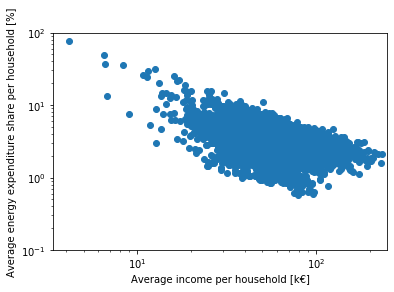

In [46]:
fig = plt.figure()
ax = plt.gca()
ax.scatter(data.loc[:,'g_ink_phh'], data.loc[:,'g_nrg_exp_share_phh']*100)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(0,250)
ax.set_ylim(0.1,100)
ax.set_xlabel('Average income per household [k€]')
ax.set_ylabel('Average energy expenditure share per household [%]')

C:\Users\dallalongaf\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  


Text(0, 0.5, 'Average energy expenditure share per person [%]')

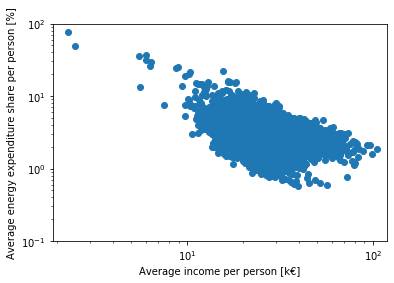

In [47]:
fig = plt.figure()
ax = plt.gca()
ax.scatter(data.loc[:,'g_ink_pi'], 100*data.loc[:,'g_nrg_exp_share_pi'])
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(0,120)
ax.set_ylim(0.1,100)
ax.set_xlabel('Average income per person [k€]')
ax.set_ylabel('Average energy expenditure share per person [%]')

In [48]:
# Classify data
# We classify each point depending on the quadrant in which they fall. 
# Our label is an integer y between 0 and 3
# exp and income risk: y = 0
# only exp risk: y = 1
# only income risk: y = 2
# no risk: y = 3

# The min wage per person in 2015 was about 1.5 kE. We take this as the threshold for the 'payment risk'.
min_wage = 1.5 * 12
# We set the threshold for the energy expenditure at the 4th quartile
ref_nrgexp = 100*data.g_nrg_exp_share_pi.quantile(0.8075) 

# energy expenditure risk column:
data.loc[:,'nrgexp_risk'] = 0
data.loc[data[data.loc[:,'g_nrg_exp_share_pi'] >= ref_nrgexp/100.].index,'nrgexp_risk'] = 1

# income risk column: 
data.loc[:,'income_risk'] = 0
data.loc[data[(data.loc[:,'g_ink_pi'] - min_wage) <= 0].index,'income_risk'] = 1

# labels column as tuples
#l = list(zip(merged.nrgexp_risk,merged.income_risk))
#merged.loc[:,'label'] = l

# labels column as integers
def map_labels_c4(y):
    """
    take label y expressed as a tuple (y1,y2) and turn it into an integer between 0 and 3   
    """
    ret = 3
    y1 = y[0]
    y2 = y[1]
    if y1 == 1 and y2 == 1: 
        ret = 0
    elif y1 == 1 and y2 == 0: 
        ret = 1
    elif y1 == 0 and y2 == 1:
        ret = 2
    return ret

# labels column as integers
def map_labels_c2(y):
    """
    take label y expressed as a tuple (y1,y2) and turn it into an integer between 0 and 1   
    """
    ret = 0
    y1 = y[0]
    y2 = y[1]
    if y1+y2>0:
        ret = 1
    return ret

data.loc[:,'label_int'] = 0
data.label_int = data[['nrgexp_risk','income_risk']].apply(map_labels_c4, axis=1)
#data.label_int = data[['nrgexp_risk','income_risk']].apply(map_labels_c2, axis=1)

data.head()

,regio,gm_naam,recs,gwb_code,a_inw,a_man,a_vrouw,a_geb,p_geb,a_ste,...,g_ink_phh,g_nrg_exp_share_phh,g_gas_exp_share_phh,g_ele_exp_share_phh,g_nrg_exp_share_pi,g_gas_exp_share_pi,g_ele_exp_share_pi,nrgexp_risk,income_risk,label_int
3,Appingedam-Centrum,Appingedam,Buurt,BU00030000,2305,1075,1230,20,8,55,...,36.72,0.048026,0.034954,0.013072,0.048026,0.034954,0.013072,1,0,1
4,Appingedam-West,Appingedam,Buurt,BU00030001,3165,1575,1595,20,6,15,...,52.56,0.040066,0.028011,0.012055,0.040066,0.028011,0.012055,0,0,3
5,Appingedam-Oost,Appingedam,Buurt,BU00030002,5970,2870,3100,55,9,75,...,38.50,0.047783,0.034318,0.013465,0.047783,0.034318,0.013465,1,1,0
6,Verspr.h. Damsterdiep en Eemskanaal,Appingedam,Buurt,BU00030007,355,185,165,0,0,0,...,66.12,0.036601,0.024550,0.012051,0.036601,0.024550,0.012051,0,0,3
8,Verspr.h. ten N. van het Damsterdiep,Appingedam,Buurt,BU00030009,150,75,75,0,0,0,...,43.75,0.069545,0.051771,0.017774,0.069545,0.051771,0.017774,1,1,0


In [49]:
round(100*data.groupby('label_int').count().iloc[:,0]/len(data),1)

label_int
0     3.5
1    15.7
2     3.5
3    77.2
Name: regio, dtype: float64

In [50]:
# Next I define a function to make scatterplots with a colorscale 
def make_scatplot(sorting_parameter,dataset=data,ascending=True,hide=True,cmap='coolwarm',marker='o',s=10,cmM=None,c=c):
    """
    Returns a scatterplot of energy expenditure share deviation vs. income deviation. 
    Takes a column from the merged df as input (sorting_parameter) to color the points. 
    cmM = Color min max, a tuple to specify min and max values on the colorscale. If None these are set automatically.
    """
    
    # sort df
    df = dataset.sort_values(by=[sorting_parameter], ascending=ascending)
    # vmin, vmax
    if cmM == None:
        vmin = df[sorting_parameter].quantile(0.05)
        vmax = df[sorting_parameter].quantile(0.95)
    elif cmM == 'stretch':
        vmin = df[sorting_parameter].min()
        vmax = df[sorting_parameter].max()
    else: 
        vmin = cmM[0]
        vmax = cmM[1]
    # set up output figure
    fig, ax = plt.subplots()
    # plot deviation from median energy expenditure share vs income per person
    if cmap is not None: # if cmap color the points
        sc = ax.scatter(df.g_ink_pi, df.g_nrg_exp_share_pi * 100, c=df[sorting_parameter].astype(float),\
                        cmap=cmap, marker=marker,s=s, vmin=vmin, vmax=vmax)
        cbar = plt.colorbar(sc)
        cbar.set_label(sorting_parameter)
    else: # if no cmap color the points with c
        ax.scatter(df.g_ink_pi, df.g_nrg_exp_share_pi * 100, marker=marker,s=s,c=c)        
    # threshold lines and plot limits
    ax.vlines(min_wage,0,100,linestyle='--',linewidth=1.)
    ax.set_ylim(0,8)
    ax.hlines(ref_nrgexp,0,120,linestyle='--',linewidth=1.)
    ax.set_xlim(0,60)
    # axes lables
    ax.set_xlabel('Income [k€/person]')
    ax.set_ylabel('Energy expenditure share [%]')
    #title
    try:
        ax.set_title(codes.loc[sorting_parameter,'cat_var'])
    except KeyError: 
        ax.set_title(sorting_parameter)    
    # don't show twice in iPython
    if hide:
        plt.close(fig)
    # return
    return fig

Text(0.5, 1.0, '')

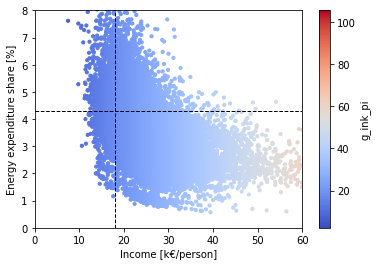

In [51]:
fig = make_scatplot('g_ink_pi', hide=False, cmM='stretch')
ax = fig.gca()
#ax.set_ylim(0,100)
ax.set_title(None)

In [52]:
#fig = make_scatplot('g_ink_pi', cmap=None, hide=False)
#ax = fig.gca()
#ax.set_xlim(0.1,100)
#ax.set_ylim(0.1,100)
#ax.set_xscale('log')
#ax.set_yscale('log')


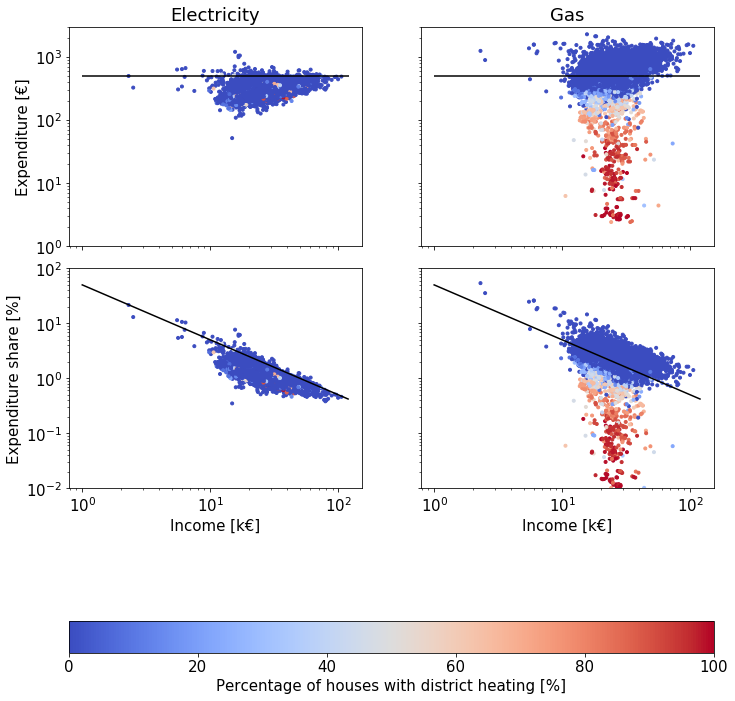

In [53]:
# Plot expenditure share vs income for elc and gas separately:

# Figure setup
plt.rcParams['font.size'] = 15
#plt.rcParams['text.usetex'] = False
colpar = 'p_stadsv'

fig,ax = plt.subplots(2,2,sharex=True,sharey=False)
fig.set_size_inches(10,10)
plt.tight_layout()

axes = [ax[0][0], ax[0][1], ax[1][0], ax[1][1]]

# Elc
ele = axes[0].scatter(data.loc[:,'g_ink_pi'],data.loc[:,'g_ele_exp']/data.loc[:,'g_hhgro'], marker='.',\
                       c=data[colpar], cmap = 'coolwarm')
axes[0].set_ylabel('Expenditure [€]')
axes[0].set_ylim(1,3000)
axes[0].set_title('Electricity')
axes[0].hlines(500,1,120,'k')

eleshare = axes[2].scatter(data.loc[:,'g_ink_pi'],data.loc[:,'g_ele_exp_share_pi']*100, marker='.',\
                       c=data[colpar], cmap = 'coolwarm')
axes[2].set_xlabel('Income [k€]')
axes[2].set_ylabel('Expenditure share [%]')
axes[2].set_ylim(0.01,100)
axes[2].plot(range(1,120),[50/float(x) for x in range(1,120)], color='black')
#a.annotate('Black line: \nuniform expenditure \nfor all incomes = \n500 €/year',(3,50/3.),xytext=(5,0.6),\
#               fontsize=10,ha='center',\
#               arrowprops={'arrowstyle':'-|>','color':'gray'})


# Gas
gas = axes[1].scatter(data.loc[:,'g_ink_pi'],data.loc[:,'g_gas_exp']/data.loc[:,'g_hhgro'], marker='.',\
                       c=data[colpar], cmap = 'coolwarm')
axes[1].set_title('Gas')
axes[1].set_ylim(1,3000)
axes[1].hlines(500,1,120,'k')
plt.setp(axes[1].get_yticklabels(), visible=False)

gasshare = axes[3].scatter(data.loc[:,'g_ink_pi'],data.loc[:,'g_gas_exp_share_pi']*100, marker='.',\
                       c=data[colpar], cmap = 'coolwarm')
axes[3].set_ylim(0.01,100)
axes[3].set_xlabel('Income [k€]')
axes[3].plot(range(1,120),[50/float(x) for x in range(1,120)], color='black')
plt.setp(axes[3].get_yticklabels(), visible=False)

# Colorbar
cbar = plt.colorbar(gasshare,ax=ax,orientation ='horizontal',anchor=(0.5,0.5))
cbar.set_label('Percentage of houses with district heating [%]')

# Details
for a in axes: 
    a.set_xscale('log')
    a.set_yscale('log')


#fig.savefig("output\\figs\\select\\elc_gas_exp.jpg",bbox_inches="tight")

In [54]:
# save all plots with larger text, no titles and larger canvas
# plt.rcParams['font.size'] = 20
# for c in data.columns[7:]:
#    f = make_scatplot(c)
#    f.gca().set_title('')
#    f.set_size_inches([12,10])
#    f.savefig('output\\figs\\%s.jpg'%c, bbox_inches="tight")


In [55]:
# merge surface temperature data
#import geopandas as gpd
#temp = gpd.read_file("GIS\\surface_temp\\nl_prj.shp")
#temp = temp[['BU_CODE','_Tmean']].dropna()
#temp.columns = ['gwb_code_10','avgT']
#print(len(temp))
#print(len(data))
#data = data.merge(temp, on='gwb_code_10', how='left')
#data = data[data.g_nrg_exp_share.notnull()].reset_index()
#print(len(data))
#data.tail()

In [56]:
#make_scatplot('avgT',hide=False)

In [57]:
100*data.g_nrg_exp_share_pi.quantile(0.75) #8075)

4.0732603098453914

In [59]:
# f=make_scatplot('g_ink_pi',cmap = None, hide=False)
# ax = f.gca()
#ax.set_ylim(-1,4)
#ax.text( -0.5,1,"0",fontsize=30,horizontalalignment='center',verticalalignment='center')
#ax.text( 2,1,"1",fontsize=30,horizontalalignment='center',verticalalignment='center')
#ax.text( -0.5,-0.5,"2",fontsize=30,horizontalalignment='center',verticalalignment='center')
#ax.text( 2,-0.5,"3",fontsize=30,horizontalalignment='center',verticalalignment='center')
#fig.savefig("output\\figs\\select\\basic.jpg",bbox_inches="tight")

In [ ]:
# fig = make_scatplot('bev_dich', hide=False, cmM=(0,30000)) #, marker='.',s=5)
# ax = fig.gca()
# #ax.set_ylim(-1,4)
# #ax.set_title(None)
# #ax.set_alpha(0.5)
# fig.set_size_inches(12,10)
#fig.savefig("output\\figs\\select\\bev_dich.jpg",bbox_inches="tight")

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


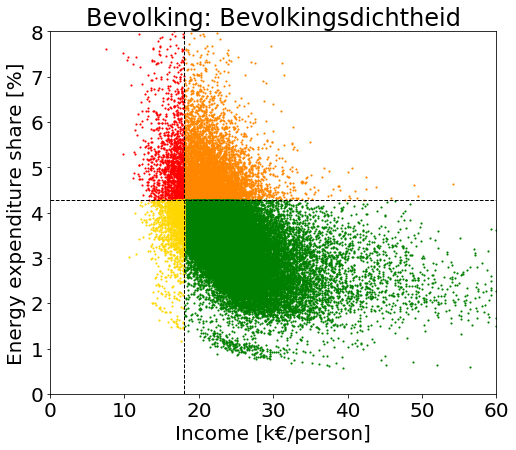

In [60]:
plt.rcParams['font.size'] = 20
fig = make_scatplot('bev_dich',dataset=data[data.label_int==0], hide=False, cmap=None,c='red', marker='.',s=5)
ax = fig.gca()
ax.scatter(x=data[data.label_int==1].loc[:,'g_ink_pi'], y=100*data[data.label_int==1].loc[:,'g_nrg_exp_share_pi'],\
           c=(255/255.,135/255.,0), marker='.',s=5)
ax.scatter(x=data[data.label_int==3].loc[:,'g_ink_pi'], y=100*data[data.label_int==3].loc[:,'g_nrg_exp_share_pi'],\
           c='green', marker='.',s=5)
ax.scatter(x=data[data.label_int==2].loc[:,'g_ink_pi'], y=100*data[data.label_int==2].loc[:,'g_nrg_exp_share_pi'],\
           c=(255/255.,215/255.,0), marker='.',s=5)

#ax.set_ylim(-1,4)
#ax.set_title(None)
#ax.set_alpha(0.5)
ax.set_xlim(0,60)
ax.set_ylim(0,8)
fig.set_size_inches(8,8*10/12.)
# fig.savefig("output\\figs\\select\\cat.jpg",bbox_inches="tight")

In [61]:
# Missing values:
# all rows contain missing values
len(data[data.isna()]) == len(data)

True

In [62]:
# First of all we want to keep all rows where all income, electricity use and gas use values are available. 
# Second, we also include rows where all values for WOZ and percentage of rented houses are available: 
df = data[data.g_ink_pi.notna() & data.g_ele.notna() & data.g_gas.notna() & data.g_woz.notna() & data.p_huurw.notna()]
# Third, we get rid of the columns with postcodes: 
df = df.drop([c for c in df.columns if 'pst_' in c], axis=1)
# We also eliminate features related to neighbohood size: 
df = df.drop([c for c in df.columns if '_ha' in c], axis=1)


In [63]:
# print a summary of nans per column
#for c in df.columns:
#    x=df.loc[:,c].isna().sum()
#    print(c, x)

In [64]:
# Now eliminate all columns that still contain nans
df = df.dropna(axis=1)
print('original number of cols: ',len(data.columns))
print('after removing NaNs: ',len(df.columns))

original number of cols:  130
after removing NaNs:  95


In [65]:
# store a list of left-out comlumns:
left_out_cols = []
for c in data.columns:
    if c not in df.columns:
        left_out_cols.append(c)

# store a list of left-out rows:
left_out_rows = []
for i in data.index:
    if i not in df.index:
        left_out_rows.append(i) #data.loc[i,'regio'])


In [66]:
df.head()

,regio,gm_naam,recs,gwb_code,a_inw,a_man,a_vrouw,a_geb,p_geb,a_ste,...,g_ink_phh,g_nrg_exp_share_phh,g_gas_exp_share_phh,g_ele_exp_share_phh,g_nrg_exp_share_pi,g_gas_exp_share_pi,g_ele_exp_share_pi,nrgexp_risk,income_risk,label_int
3,Appingedam-Centrum,Appingedam,Buurt,BU00030000,2305,1075,1230,20,8,55,...,36.72,0.048026,0.034954,0.013072,0.048026,0.034954,0.013072,1,0,1
4,Appingedam-West,Appingedam,Buurt,BU00030001,3165,1575,1595,20,6,15,...,52.56,0.040066,0.028011,0.012055,0.040066,0.028011,0.012055,0,0,3
5,Appingedam-Oost,Appingedam,Buurt,BU00030002,5970,2870,3100,55,9,75,...,38.50,0.047783,0.034318,0.013465,0.047783,0.034318,0.013465,1,1,0
6,Verspr.h. Damsterdiep en Eemskanaal,Appingedam,Buurt,BU00030007,355,185,165,0,0,0,...,66.12,0.036601,0.024550,0.012051,0.036601,0.024550,0.012051,0,0,3
8,Verspr.h. ten N. van het Damsterdiep,Appingedam,Buurt,BU00030009,150,75,75,0,0,0,...,43.75,0.069545,0.051771,0.017774,0.069545,0.051771,0.017774,1,1,0


In [67]:
round(df.groupby('label_int').count().iloc[:,0] / len(df),2)

label_int
0    0.04
1    0.16
2    0.04
3    0.77
Name: regio, dtype: float64

In [68]:
df.groupby('label_int').count().iloc[:,0]

label_int
0     1478
1     6573
2     1477
3    32294
Name: regio, dtype: int64

In [69]:
# let's thin the datasheet by making classes 1 and 3 smaller 
#rows_to_drop = list(df[(df.label_int == 1) & (df.year != 2015)].index) # keep only data for 2015
#df = df.drop(rows_to_drop, axis=0)
#rows_to_drop = list(df[(df.label_int == 3) & (df.year != 2015)].index) # keep only data for 2015
#df = df.drop(rows_to_drop, axis=0)
import random
pts = df.groupby('label_int').count().iloc[:,0]
pts_to_keep = pts.min()
for i in pts.index:
    rows_to_drop = random.sample(list(df[(df.label_int == i)].index), k=pts[i]-pts_to_keep) # keep only ~2000 datapoints
    df = df.drop(rows_to_drop, axis=0)

df.groupby('label_int').count().iloc[:,0]


label_int
0    1477
1    1477
2    1477
3    1477
Name: regio, dtype: int64

In [70]:
#import random
#pts = df.groupby('label_int').count().iloc[:,0]
#pts_to_keep = min(pts)
#rows_to_drop = random.sample(list(df[(df.label_int == 0)].index), k=pts[0]-pts_to_keep)
#df = df.drop(rows_to_drop, axis=0)
#rows_to_drop = random.sample(list(df[(df.label_int == 1)].index), k=pts[1]-pts_to_keep)
#df = df.drop(rows_to_drop, axis=0)
#rows_to_drop = random.sample(list(df[(df.label_int == 2)].index), k=pts[2]-pts_to_keep)
#df = df.drop(rows_to_drop, axis=0)
#rows_to_drop = random.sample(list(df[(df.label_int == 3)].index), k=pts[3]-pts_to_keep)
#df = df.drop(rows_to_drop, axis=0)
#df.groupby('label_int').count().iloc[:,0]

In [169]:
from sklearn.metrics import confusion_matrix
classes_labels = ['double risk','expenditure risk','income risk','no risk']
classes_labels_2 = ['double risk','expenditure risk']

def make_confusion_matrix(test_feats, test_targets, model):
    cm = confusion_matrix(test_feats, model.predict(test_targets))
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
    im.set_clim(0.,1.)
    cbar = fig.colorbar(im, ticks=np.arange(0,1.2,0.2),fraction=0.0455)
    cbar.ax.set_yticklabels(['%s%%'%i for i in range(0,120,20)])

    ax.set_ylim(-0.5,3.5)
    ax.set_yticks([0,1,2,3])
    ax.set_yticklabels(classes_labels)
    ax.set_ylabel('True label')
    ax.set_xticks([0,1,2,3])
    ax.set_xticklabels(classes_labels, rotation=45, ha='right')
    ax.set_xlabel('Predicted label')
    ax.invert_yaxis()

    # Loop over data dimensions and create text annotations.
    fmt = '.0%'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    return fig

def make_confusion_matrix_2(test_feats, test_targets, model):
    cm = confusion_matrix(test_feats, model.predict(test_targets))
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
    im.set_clim(0.,1.)
    cbar = fig.colorbar(im, ticks=np.arange(0,1.2,0.2),fraction=0.0455)
    cbar.ax.set_yticklabels(['%s%%'%i for i in range(0,120,20)])
    
   
    ax.set_ylim(-0.5,3.5)
    ax.set_yticks([0,1,2,3])
    ax.set_yticklabels(classes_labels)
    ax.set_ylabel('True label')
    ax.set_xticks([0,1,2,3])
    ax.set_xticklabels(classes_labels, rotation=45, ha='right')
    ax.set_xlabel('Predicted label')
   
    # Loop over data dimensions and create text annotations.
    fmt = '.0%'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    return fig
  



In [203]:
df_sel = df.drop('year', axis=1)

# Only predict labels 0 and 2: 
#df = df[(df.label_int == 0) | (df.label_int == 2)]

selected_feats = ['g_ink_pi','p_huurw','p_bjo2k','g_woz','g_hhgro', 'bev_dich'] #,'g_ink_pi']#,'g_nrg_exp_share','label_int']]
#selected_feats = ['p_huurw','p_bjo2k','g_woz','g_hhgro', 'bev_dich'] #,'g_ink_pi']#,'g_nrg_exp_share','label_int']]


In [205]:
plt.rcParams['font.size'] = 20
for c in selected_feats:
    f = make_scatplot(c,cmM=(df[c].quantile(0.1),df[c].quantile(0.9)))
    f.gca().set_title('  ')
    #f.gca().set_ylim(-1,4)
    f.set_size_inches(12,10)
    f.savefig('output\\figs\\select\\%s.jpg'%c, bbox_inches="tight")

1


KeyboardInterrupt: 

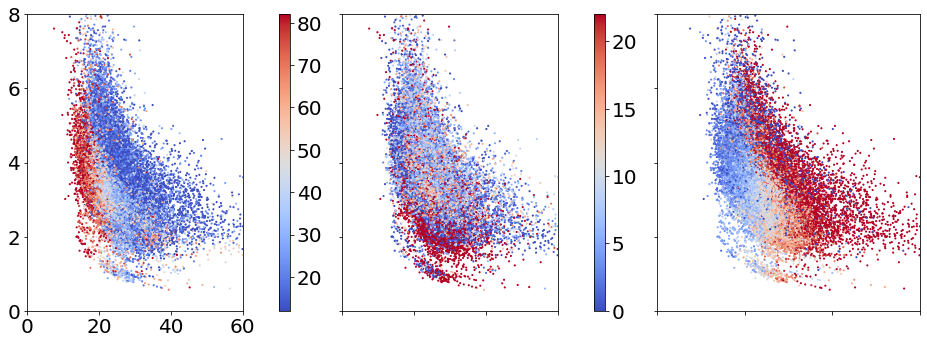

In [204]:
# from mpl_toolkits.axes_grid1 import make_axes_locatable

# fig = plt.figure(figsize=(16, 12))
# axs = []
# ims = []

# for i in range(1,6,1):
#     c = selected_feats[i]
#     sub = 230+i
    
#     if i == 1:
#         print(i)
#         a = fig.add_subplot(sub)
#     else: 
#         a = fig.add_subplot(sub, sharex=a1, sharey=a1)
        
#     im = a.scatter(data.g_ink_pi, data.g_nrg_exp_share_pi * 100, c=data[c].astype(float),\
#                    cmap='coolwarm', marker='.',s=5,\
#                    vmin = df[c].quantile(0.10),vmax = df[c].quantile(0.90))
#     a.set_xlim(0,60)
#     a.set_ylim(0,8)

#     divider = make_axes_locatable(a)
#     cax = divider.append_axes('right', size='5%', pad=0.5)
#     fig.colorbar(im, cax=cax, orientation='vertical')




In [199]:
# Targets as numpy arrays
targets = np.array(df_sel.loc[:,'label_int'])
#targets = np.array(df.loc[:,'nrgexp_risk'])

# In order to define the features, we remove columns that contain _ink, _gas and _ele 
# (these are used to classify our data algorithmically, so they should not be part of the ML analysis)

#ink_cols = [c for c in df_sel.columns if '_ink' in c]
gas_cols = [c for c in df_sel.columns if '_gas' in c]
ele_cols = [c for c in df_sel.columns if '_ele' in c]

#df_sel = df_sel.drop(ink_cols, axis=1)
df_sel = df_sel.drop(gas_cols, axis=1)
df_sel = df_sel.drop(ele_cols, axis=1)

# redefine last_feat, in case that was one of the dropped cols:
if selected_feats:
    features = np.array(df_sel.loc[:,selected_feats])
    features_names = list(df_sel.loc[:,selected_feats].columns)
else: 
    last_feat = df_sel.columns[df_sel.columns.get_loc('g_nrg_exp_share_pi')-1]
    # Features as numpy arrays
    features = np.array(df_sel.loc[:,first_feat:last_feat])
    features_names = list(df_sel.loc[:,first_feat:last_feat].columns)


In [200]:
# gradient boosting (sklearn or xgboost)
import xgboost as xgb
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn import preprocessing 
from sklearn.metrics import classification_report

features_norm = features #preprocessing.normalize(features)
X_train, X_test, y_train, y_test = train_test_split(features_norm, targets, test_size=0.3, stratify=targets)

max_depth = 5
#dmatrix = xgb.DMatrix(X_train, y_train, feature_names=features_names)
dmatrix = xgb.DMatrix(X_train, y_train, feature_names=list(codes.loc[[f for f in features_names],'cat_var']))

xgb_clf = xgb.XGBClassifier(max_depth=max_depth) #, base_score=df.label_int.mean())
#xgb_clf = ensemble.GradientBoostingClassifier(max_depth=max_depth)

xgb_model = xgb_clf.fit(X_train, y_train)

# score
print("Training set")
print(classification_report(y_train, xgb_model.predict(X_train)))
print("Test set")
print(classification_report(y_test, xgb_model.predict(X_test)))

Training set
              precision    recall  f1-score   support

           0       0.76      0.66      0.71      1034
           1       0.70      0.80      0.75      1034
           2       0.79      0.86      0.82      1033
           3       0.78      0.70      0.74      1034

    accuracy                           0.76      4135
   macro avg       0.76      0.76      0.75      4135
weighted avg       0.76      0.76      0.75      4135

Test set
              precision    recall  f1-score   support

           0       0.56      0.51      0.54       443
           1       0.63      0.68      0.65       443
           2       0.68      0.74      0.71       444
           3       0.67      0.62      0.64       443

    accuracy                           0.64      1773
   macro avg       0.64      0.64      0.64      1773
weighted avg       0.64      0.64      0.64      1773



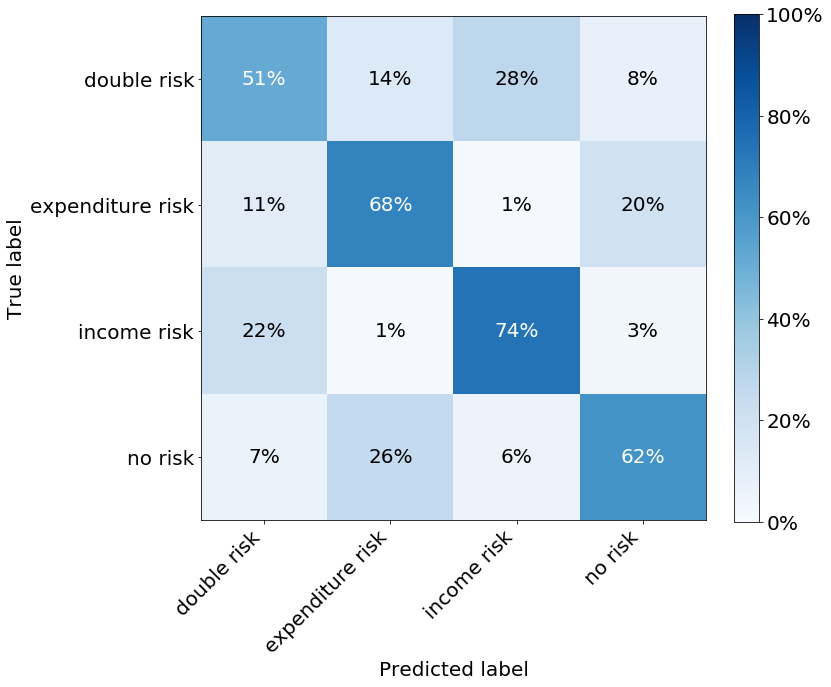

In [201]:
c_matrix = make_confusion_matrix(y_test,X_test,xgb_model)
plt.rcParams['font.size'] = 20
c_matrix.set_size_inches([10,10])
c_matrix.savefig('output\\figs\\select\\no_inc.jpg', bbox_inches="tight")
#else: 
#    c_matrix.savefig('output\\figs\\select\\best_cm_ink.jpg', bbox_inches="tight")

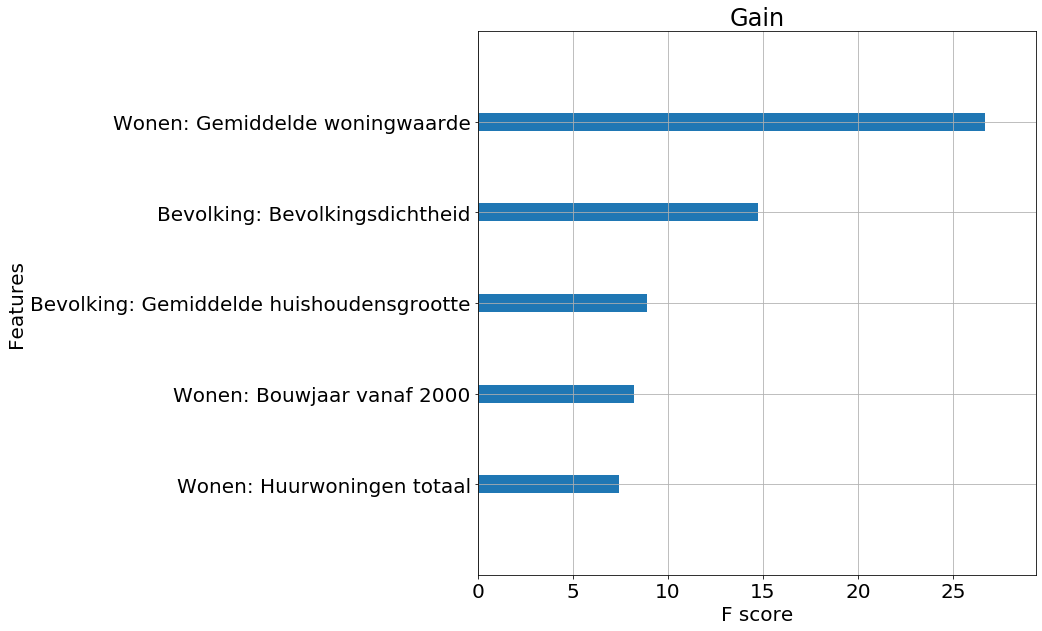

In [202]:
plt.rcParams['font.size'] = 20
param = {'max_depth':max_depth}
xgb_train = xgb.train(param, dmatrix)
fig, ax = plt.subplots()
fig.set_size_inches(10,10)
xgb.plot_importance(xgb_train,importance_type='gain', show_values=False, title='Gain', ax=ax)
fig.savefig('output\\figs\\select\\no_inc_importance.jpg', bbox_inches="tight")

In [102]:
#impos = xgb_train.get_score(importance_type='gain')
#impos_df = pd.DataFrame.from_dict({'feat': codes.loc[list(impos.keys()),'cat_var'],\
#                        'fscore': list(impos.values())}, orient='columns')\
#                        .sort_values(by='fscore', ascending = False)
#impos_df #.head(6)

In [54]:
#xgb_model.get_booster().dump_model("out.txt")

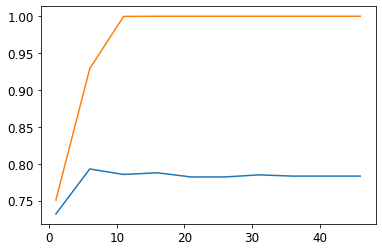

In [56]:
from sklearn.metrics import f1_score
scores = []
scores_train = []
steps = range(1,50,5)
for md in steps:
    max_depth = md
    xgb_clf = xgb.XGBClassifier(max_depth=md)
    xgb_model = xgb_clf.fit(X_train, y_train)
    scores.append(f1_score(y_test, xgb_model.predict(X_test), average='weighted'))
    scores_train.append(f1_score(y_train, xgb_model.predict(X_train),  average='weighted'))
plt.plot(steps,scores, steps,scores_train)

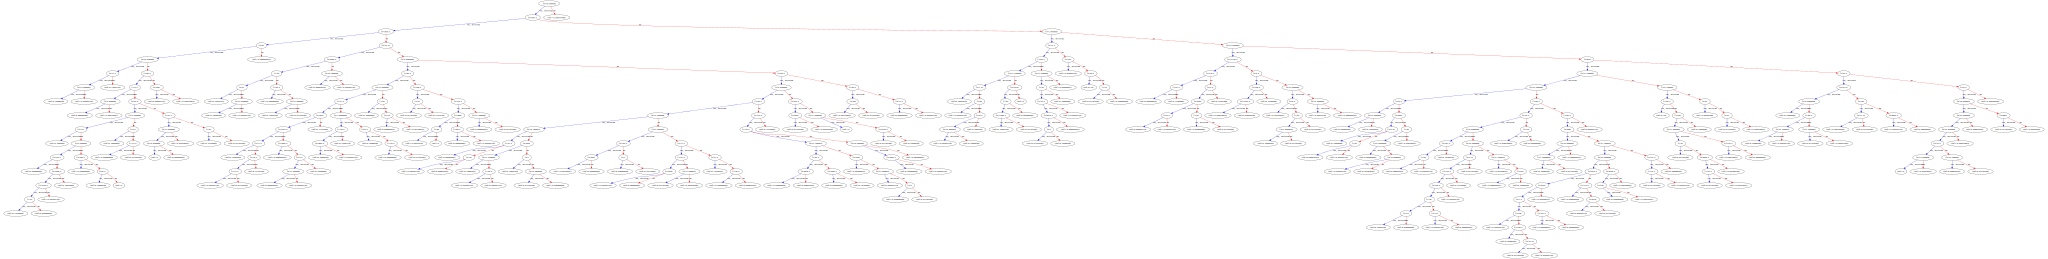

In [56]:
from xgboost import plot_tree
from sklearn.tree import export_graphviz
from sklearn import tree
#fig, ax = plt.subplots()
#fig.set_figwidth(90)
#xgb.plot_tree(xgb_model) #, num_trees=0, ax=ax)
xgb.to_graphviz(xgb_model, num_trees=0) #, feature_names=dmatrix.feature_names)


#dot_data = tree.export_graphviz(xgb_model.get_booster().get_dump()[0], out_file=None, feature_names=dmatrix.feature_names) #,  
                      #class_names=iris.target_names,  
                      #filled=True, rounded=True,  
                      #special_characters=True)  
#graph = graphviz.Source(dot_data)  
#graph


In [210]:
from dtreeviz.trees import *

classifier = tree.DecisionTreeClassifier(max_depth=3)  # limit depth of tree
classifier.fit(X_train,y_train)


viz = dtreeviz(classifier, 
               X_test,
               y_test,
               target_name='poverty class',
               feature_names=dmatrix.feature_names, 
               class_names=["double", "expenditure", "income","none"]  # need class_names for classifier
               )  
              
viz.view() 
classifier

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [199]:
from dtreeviz.trees import *
for i in range(3):
    viz = dtreeviz(xgb_model.estimators_[0,i], 
               X_test,
               y_test,
               target_name='poverty class',
               feature_names=features_names, 
               class_names=["double", "expenditure", "income","none"]  # need class_names for classifier
               )  
              
    viz.view() 


In [58]:
xgb_model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=46,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [59]:
#for i in impos_df[impos_df.fscore > 20].index:
#    make_scatplot(i,hide=False)

In [130]:
# Let's try to build an xgboost model using only these most important features
# Features as numpy arrays
features_small = np.array(df.loc[:,impos_df[impos_df.fscore > 25].index])
features_small_names = list(df.loc[:,impos_df[impos_df.fscore > 25].index].columns)
# targets remain the same

features_small_norm = preprocessing.normalize(features_small)
X_train, X_test, y_train, y_test = train_test_split(features_small_norm, targets, test_size=0.33, stratify = targets)

max_depth = 5
dmatrix_small = xgb.DMatrix(X_train, y_train, feature_names=features_small_names)
#dmatrix = xgb.DMatrix(X_train, y_train, feature_names=list(codes.loc[[f for f in features_small_names],'cat_var']))
xgb_clf_small = xgb.XGBClassifier(max_depth=max_depth) #, base_score=df.label_int.mean())
xgb_model_small = xgb_clf_small.fit(X_train, y_train)

# score
print("Training set")
print(classification_report(y_train, xgb_model_small.predict(X_train)))
print("Test set")
print(classification_report(y_test, xgb_model_small.predict(X_test)))

Training set
              precision    recall  f1-score   support

           0       0.62      0.21      0.31      1085
           1       0.58      0.81      0.68       779
           2       0.56      0.66      0.61       894
           3       0.51      0.63      0.56      1085

   micro avg       0.56      0.56      0.56      3843
   macro avg       0.57      0.58      0.54      3843
weighted avg       0.57      0.56      0.53      3843

Test set
              precision    recall  f1-score   support

           0       0.39      0.12      0.18       535
           1       0.51      0.72      0.60       383
           2       0.51      0.59      0.55       441
           3       0.45      0.57      0.50       535

   micro avg       0.48      0.48      0.48      1894
   macro avg       0.46      0.50      0.46      1894
weighted avg       0.46      0.48      0.44      1894



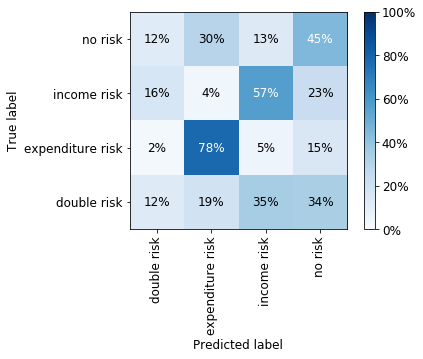

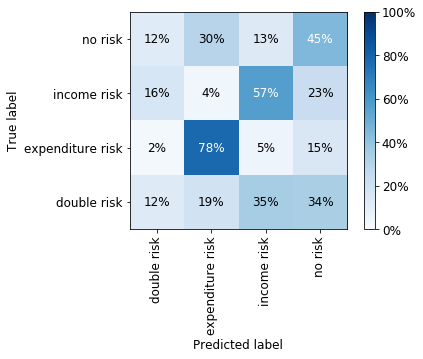

In [129]:
make_confusion_matrix(y_test,X_test,xgb_model_small)

Training set
              precision    recall  f1-score   support

           0       0.89      0.66      0.76      1177
           1       0.82      0.75      0.78      5829
           2       0.91      0.69      0.78       803
           3       0.92      0.96      0.94     20211

   micro avg       0.90      0.90      0.90     28020
   macro avg       0.88      0.76      0.81     28020
weighted avg       0.90      0.90      0.89     28020

Test set
              precision    recall  f1-score   support

           0       0.71      0.43      0.53       579
           1       0.74      0.65      0.69      2871
           2       0.74      0.48      0.58       396
           3       0.88      0.95      0.91      9956

   micro avg       0.85      0.85      0.85     13802
   macro avg       0.77      0.63      0.68     13802
weighted avg       0.84      0.85      0.84     13802



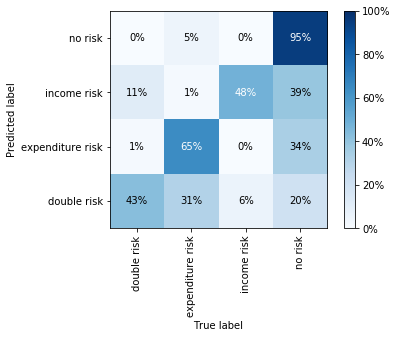

In [46]:
# Let's try to build an xgboost model using only a few more important features
# Features as numpy arrays
features_small = np.array(df.loc[:,impos_df[impos_df.fscore > 5].index])
features_small_names = list(df.loc[:,impos_df[impos_df.fscore > 5].index].columns)
# targets remain the same

features_small_norm = preprocessing.normalize(features_small)
X_train, X_test, y_train, y_test = train_test_split(features_small_norm, targets, test_size=0.33, stratify = targets)

max_depth = 5
dmatrix_small = xgb.DMatrix(X_train, y_train, feature_names=features_small_names)
#dmatrix = xgb.DMatrix(X_train, y_train, feature_names=list(codes.loc[[f for f in features_small_names],'cat_var']))
xgb_clf_small = xgb.XGBClassifier(max_depth=max_depth)
xgb_model_small = xgb_clf_small.fit(X_train, y_train)

# score
print("Training set")
print(classification_report(y_train, xgb_model_small.predict(X_train)))
print("Test set")
print(classification_report(y_test, xgb_model_small.predict(X_test)))

make_confusion_matrix(y_test,X_test,xgb_model_small)

In [82]:
# Let's try to build an xgboost model using only these most important features
# and using k-fold cross validation
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict

# Features as numpy arrays
features_small = np.array(df.loc[:,impos_df[impos_df.fscore > 20].index])
features_small_names = list(df.loc[:,impos_df[impos_df.fscore > 20].index].columns)
# targets remain the same

features_small_norm = preprocessing.normalize(features_small)

max_depth = 5
dmatrix_small = xgb.DMatrix(X_train, y_train, feature_names=features_small_names)
xgb_clf_small = xgb.XGBClassifier(max_depth=max_depth)
kfold = StratifiedKFold(n_splits=10)
results = cross_val_score(xgb_clf_small, features_small_norm, targets, cv=kfold, scoring='f1_macro')
predictions = cross_val_predict(xgb_clf_small, features_small_norm, targets, cv=kfold)
print(round(results.mean(),2), round(results.std(),2))


0.5 0.06


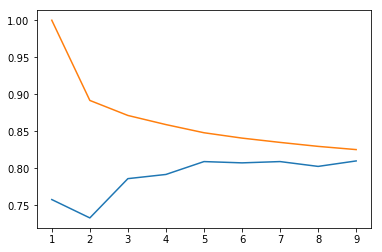

In [33]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

features_norm = preprocessing.normalize(features)
X_train, X_test, y_train, y_test = train_test_split(features_norm, targets)

#knn = KNeighborsClassifier(n_neighbors = 1)
#knn.fit(X_train, y_train)

x = []
y_tst = []
y_trn = []
for i in range(1,10):
    knn = KNeighborsClassifier(n_neighbors = i, metric='manhattan')
    knn.fit(X_train, y_train)

    x.append(i)
    y_tst.append(knn.score(X_test, y_test))
    y_trn.append(knn.score(X_train, y_train))
    
plt.plot(x, y_tst, x, y_trn)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=10, p=2,
           weights='distance')

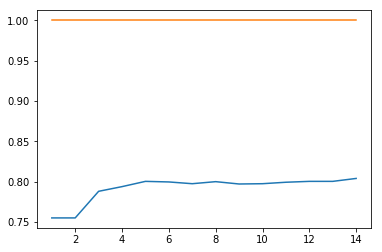

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing

features_norm = preprocessing.normalize(features)
X_train, X_test, y_train, y_test = train_test_split(features_norm, targets, test_size = 0.3)

#knn = KNeighborsClassifier(n_neighbors = 1)
#knn.fit(X_train, y_train)

x = []
y_tst = []
y_trn = []
for i in range(1,15):
    knn = KNeighborsClassifier(n_neighbors = i, weights='distance', metric='manhattan')
    knn.fit(X_train, y_train)

    x.append(i)
    y_tst.append(knn.score(X_test, y_test))
    y_trn.append(knn.score(X_train, y_train))
    
plt.plot(x, y_tst, x, y_trn)

knn = KNeighborsClassifier(n_neighbors = 10, weights='distance')
knn.fit(X_train, y_train)

In [38]:
# SVM
from sklearn import svm
from sklearn.metrics import classification_report

features_norm = preprocessing.normalize(features)
X_train, X_test, y_train, y_test = train_test_split(features_norm, targets)#, test_size=0.5)

# class weights dict
cw_dct = {0: 1/80., 1: 1/2., 2: 1/20., 3: 1/2.}
# create a classifier
clf = svm.SVC(C=10, gamma=0.1, class_weight='balanced')
# fit it to the model
clf.fit(X_train, y_train)  

# score
print("Training set")
print(classification_report(y_train, clf.predict(X_train)))
print("Test set")
print(classification_report(y_test, clf.predict(X_test)))

Training set
              precision    recall  f1-score   support

           0       0.18      0.72      0.29       229
           1       0.51      0.69      0.58      1310
           2       0.16      0.77      0.26       137
           3       0.94      0.64      0.76      5222

   micro avg       0.66      0.66      0.66      6898
   macro avg       0.45      0.71      0.48      6898
weighted avg       0.82      0.66      0.70      6898

Test set
              precision    recall  f1-score   support

           0       0.19      0.60      0.29        94
           1       0.50      0.72      0.59       436
           2       0.14      0.73      0.24        41
           3       0.95      0.64      0.77      1729

   micro avg       0.66      0.66      0.66      2300
   macro avg       0.45      0.67      0.47      2300
weighted avg       0.82      0.66      0.70      2300



In [39]:
# Decision trees
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import classification_report

features_norm = preprocessing.normalize(features)
X_train, X_test, y_train, y_test = train_test_split(features_norm, targets, test_size=0.5)

clf = DecisionTreeClassifier(max_depth=5)
clf = clf.fit(X_train, y_train)

# score
print("Training set")
print(classification_report(y_train, clf.predict(X_train)))
print("Test set")
print(classification_report(y_test, clf.predict(X_test)))

Training set
              precision    recall  f1-score   support

           0       0.55      0.45      0.49       161
           1       0.63      0.59      0.61       872
           2       0.45      0.33      0.38        87
           3       0.88      0.91      0.89      3479

   micro avg       0.82      0.82      0.82      4599
   macro avg       0.63      0.57      0.59      4599
weighted avg       0.81      0.82      0.82      4599

Test set
              precision    recall  f1-score   support

           0       0.45      0.31      0.37       162
           1       0.54      0.54      0.54       874
           2       0.29      0.20      0.24        91
           3       0.86      0.88      0.87      3472

   micro avg       0.78      0.78      0.78      4599
   macro avg       0.53      0.48      0.50      4599
weighted avg       0.77      0.78      0.78      4599



In [49]:
from sklearn import datasets
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC

print(__doc__)

# Split the dataset in two equal parts
features_norm = preprocessing.normalize(features)
X_train, X_test, y_train, y_test = train_test_split(features_norm, targets, test_size=0.5)

# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [0.001, 0.01, 0.1, 1],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

scores = ['f1']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(class_weight='balanced'), tuned_parameters, cv=10, scoring='%s_macro' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

Automatically created module for IPython interactive environment
# Tuning hyper-parameters for f1



C:\Users\dallalongaf\AppData\Local\Enthought\Canopy\edm\envs\CepPy3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\dallalongaf\AppData\Local\Enthought\Canopy\edm\envs\CepPy3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\dallalongaf\AppData\Local\Enthought\Canopy\edm\envs\CepPy3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\dallalongaf\AppData\Local\Enthought\Canopy\edm\envs\CepPy3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-d

KeyboardInterrupt: 

In [ ]:
# GIS stuff

In [18]:
# Build an energy poverty score by multiplying 
# -income deviation x nrg_exp_share deviation
income_data.loc[:,'score'] = -income_data.loc[:,'income_dev'] * income_data.loc[:,'nrg_exp_dev']
income_data.loc[:,'score_med'] = -income_data.loc[:,'income_dev_med'] * income_data.loc[:,'nrg_exp_dev_med']

income_data.head()

,wijk,regio,regio_code,bevolking,elc_kWh,gas_m3,income_kEpp,gas_GJ,elc_MWh,gas_price,elc_price,avg_gas_exp_EUR,avg_elc_exp_EUR,avg_nrg_exp_share,income_dev,nrg_exp_dev,income_dev_med,nrg_exp_dev_med,score,score_med
0,Nederland,Nederland,0,16900726.0,2980.0,1250.0,24.1,43.9625,2.98,21.476,0.066,944.138650,196.68,0.021814,-0.020817,-0.213094,0.016878,-0.192477,-0.004436,0.003249
1,Appingedam,Appingedam,0,12011.0,2660.0,1450.0,20.8,50.9965,2.66,21.476,0.066,1095.200834,175.56,0.028154,-0.154896,0.015602,-0.122363,0.042212,0.002417,0.005165
2,Wijk 00,Appingedam,1,12010.0,2660.0,1450.0,20.8,50.9965,2.66,21.476,0.066,1095.200834,175.56,0.028154,-0.154896,0.015602,-0.122363,0.042212,0.002417,0.005165
3,Appingedam-Centrum,Appingedam,1,2330.0,2390.0,1410.0,22.7,49.5897,2.39,21.476,0.117,1064.988397,279.63,0.027297,-0.077699,-0.015317,-0.042194,0.010482,-0.001190,0.000442
4,Appingedam-West,Appingedam,1,3115.0,2980.0,1530.0,23.2,53.8101,2.98,21.476,0.066,1155.625708,196.68,0.026861,-0.057384,-0.031031,-0.021097,-0.005643,-0.001781,-0.000119


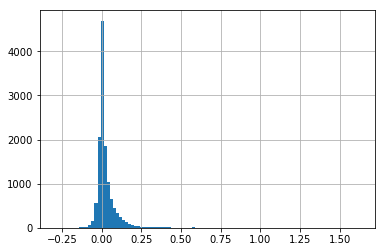

In [19]:
income_data['score'].hist(bins=100)

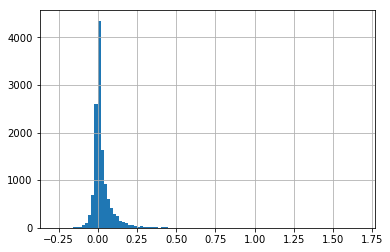

In [20]:
income_data['score_med'].hist(bins=100)

In [47]:
nl = gpd.read_file("buurt_2015//buurt_2015.shp")
nl.head()

,BU_CODE,BU_NAAM,WK_CODE,GM_CODE,GM_NAAM,IND_WBI,WATER,POSTCODE,DEK_PERC,OAD,...,AV50ATTRAC,AF_PODIUM,AV5_PODIUM,AV10PODIUM,AV20PODIUM,AF_POP,OPP_TOT,OPP_LAND,OPP_WATER,geometry
0,BU00030000,Appingedam-Centrum,WK000300,GM0003,Appingedam,1,NEE,9901,1,1161,...,11.0,5.3,0.1,1.0,1.0,24.5,90,84,5,"POLYGON ((253641.5000285022 594417.8125356995,..."
1,BU00030001,Appingedam-West,WK000300,GM0003,Appingedam,1,NEE,9903,5,881,...,11.7,6.3,0.0,1.0,1.0,23.6,163,158,5,"POLYGON ((251427.7758284993 594486.7471357025,..."
2,BU00030002,Appingedam-Oost,WK000300,GM0003,Appingedam,1,NEE,9902,1,1084,...,11.0,5.1,0.4,1.0,1.0,25.1,295,284,11,"POLYGON ((254580.6743285023 594573.5057356991,..."
3,BU00030007,Verspreide huizen Damsterdiep en Eemskanaal,WK000300,GM0003,Appingedam,1,NEE,9903,4,348,...,11.6,7.0,0.0,1.0,1.0,23.7,559,540,19,"POLYGON ((249539.9504285008 593217.5788356997,..."
4,BU00030008,Verspreide huizen ten zuiden van Eemskanaal,WK000300,GM0003,Appingedam,1,NEE,9902,1,72,...,13.5,7.7,0.0,1.0,1.1,22.9,582,554,28,"POLYGON ((254983.2482285015 592485.9826356992,..."


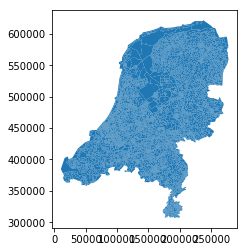

In [42]:
nl.plot()

In [50]:
to_merge = income_data.loc[:,['wijk','score','score_med']]
to_merge.columns = ['BU_NAAM','score','score_med']
to_merge.head()

,BU_NAAM,score,score_med
0,Nederland,-0.004436,0.003249
1,Appingedam,0.002417,0.005165
2,Wijk 00,0.002417,0.005165
3,Appingedam-Centrum,-0.001190,0.000442
4,Appingedam-West,-0.001781,-0.000119


In [51]:
nl_merged = nl.merge(to_merge,on='BU_NAAM',how='left')

C:\Users\dallalongaf\AppData\Local\Enthought\Canopy\edm\envs\CepPy3\lib\site-packages\matplotlib\colors.py:494: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


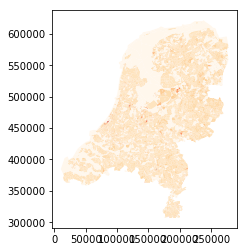

In [54]:
nl_merged.plot(column='score', cmap='OrRd')

C:\Users\dallalongaf\AppData\Local\Enthought\Canopy\edm\envs\CepPy3\lib\site-packages\matplotlib\colors.py:494: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


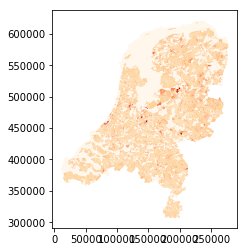

In [70]:
vmin = income_data.score_med.min()
vmax = income_data.score_med.max() * 0.5
nl_merged.plot(column='score_med', cmap='OrRd', vmin=vmin, vmax=vmax)

In [55]:
# export gpd DF for QGIS processing
nl_merged.to_file("nl.shp")

In [161]:
print('hello world!')

hello world!
